# look at train/val loss

In [1]:
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math


/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/taheeraa/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
swin_simim_file = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/07-transformer-ssl/swin_base_simmim/combined_slurm_files.out"
vit_file = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/06-transformers-pre-trained/vit_base_imagenet_1k_sgd_64_bce_True/combined_output.out"
swin_file = "/cluster/home/taheeraa/code/BenchmarkTransformers/models/classification/ChestXray14/06-transformers-pre-trained/swin_base_imagenet_1k_sgd_64_bce_aug/combined_output.out"

In [3]:
import re



def parse_line(line):
    # Updated pattern to ensure full scientific notation is captured
    pattern = r"Loss ([\d\.]+e[+-]?\d+)"
    loss_match = re.search(pattern, line)
    if loss_match:
        try:
            return float(loss_match.group(1))
        except ValueError as e:
            print(f"Error converting {loss_match.group(1)} to float: {e}")
            return None
    else:
        print("No valid loss found in line")
    return None

def extract_average_losses(file_path):
    current_epoch = None
    current_epoch_train_losses = []
    current_epoch_val_losses = []
    epoch_train_losses = []
    epoch_val_losses = []

    with open(file_path, 'r') as file:
        for line in file:
            # Extract epoch number from training or validation lines
            epoch_match = re.search(r"\[\s*(\d+)\]", line)
            if epoch_match:
                epoch_number = int(epoch_match.group(1))
                # If the epoch number changes and there are recorded losses, calculate averages
                if current_epoch is not None and epoch_number != current_epoch:
                    if current_epoch_train_losses:
                        epoch_train_losses.append(sum(current_epoch_train_losses) / len(current_epoch_train_losses))
                        current_epoch_train_losses = []
                    if current_epoch_val_losses:
                        epoch_val_losses.append(sum(current_epoch_val_losses) / len(current_epoch_val_losses))
                        current_epoch_val_losses = []
                current_epoch = epoch_number
            
            # Determine if the line is about training or validation and collect losses
            if "Loss" in line:
                loss = parse_line(line)
                if loss is not None:
                    if "Epoch" in line:
                        current_epoch_train_losses.append(loss)
                    elif "Val" in line:
                        current_epoch_val_losses.append(loss)

        # Append the last epoch's average losses if not already done
        if current_epoch_train_losses:
            epoch_train_losses.append(sum(current_epoch_train_losses) / len(current_epoch_train_losses))
        if current_epoch_val_losses:
            epoch_val_losses.append(sum(current_epoch_val_losses) / len(current_epoch_val_losses))

    return epoch_train_losses, epoch_val_losses

train_losses_vit, val_losses_vit = extract_average_losses(vit_file)

In [4]:
train_losses_swin, val_losses_swin = extract_average_losses(swin_file)
train_losses_swin_simim, val_losses_swin_simim = extract_average_losses(swin_simim_file)

In [5]:
def smooth_data(data, window_size):
    """ Smooth data using a simple moving average """
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')

def plot_losses(train_losses, val_losses, name, file, window_size=10):
    # Colors
    color_train = '#FFAFCC'  # Soft Pink
    color_val = '#A2D2FF'    # Soft Blue

    smoothed_train_losses = smooth_data(train_losses, window_size)
    smoothed_val_losses = smooth_data(val_losses, window_size)
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=smoothed_train_losses, label='Training loss', color=color_train)
    sns.lineplot(data=smoothed_val_losses, label='Validation loss', color=color_val)
    plt.title(f"Training and validation loss for {name}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    #plt.xlim(0,600)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file}.png")

plot_losses(train_losses_base, val_losses_base, "ViT pre-trained IN1k", "vit-pretrained-in1k")


NameError: name 'train_losses_base' is not defined

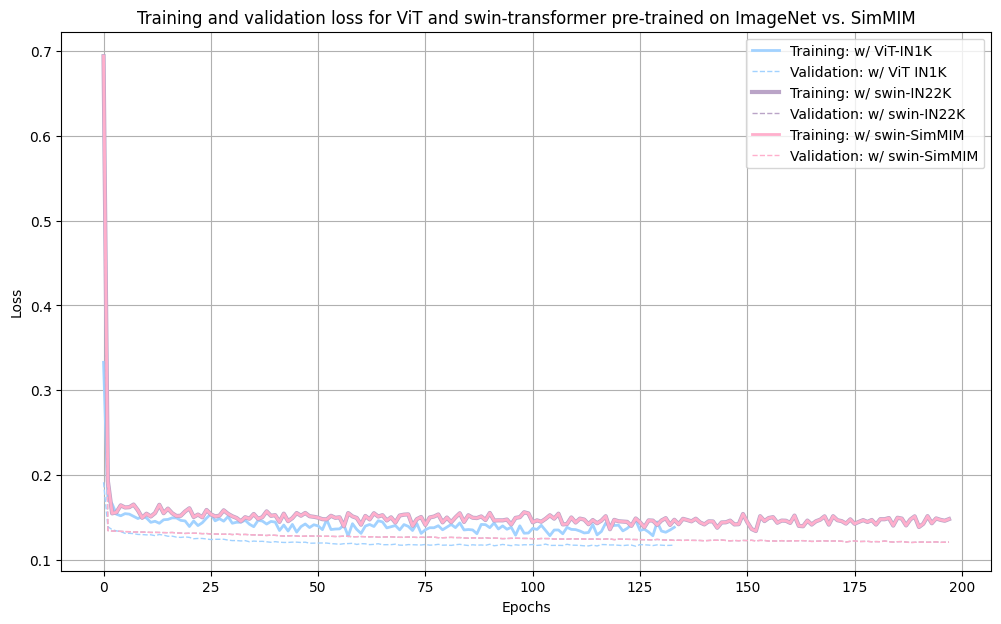

In [9]:
epochs_swin = range(len(train_losses_swin))
epochs_vit = range(len(train_losses_vit))

# Colors as specified
color_class = '#BAA4C7'  # Purple
color_32 = '#FFAFCC'     # Pink
color_no_aug = '#A2D2FF' # Blue

# Set up the plot
plt.figure(figsize=(12, 7))


sns.lineplot(x=epochs_vit, y=train_losses_vit, label='Training: w/ ViT-IN1K', color=color_no_aug, linewidth=2)
sns.lineplot(x=epochs_vit, y=val_losses_vit, label='Validation: w/ ViT IN1K', color=color_no_aug, linewidth=1, linestyle='--')

# Plotting training losses
sns.lineplot(x=epochs_swin, y=train_losses_swin, label='Training: w/ swin-IN22K', color=color_class, linewidth=3)
sns.lineplot(x=epochs_swin, y=val_losses_swin, label='Validation: w/ swin-IN22K', color=color_class, linewidth=1, linestyle='--')

sns.lineplot(x=epochs_swin, y=train_losses_swin, label='Training: w/ swin-SimMIM', color=color_32, linewidth=2)
sns.lineplot(x=epochs_swin, y=val_losses_swin, label='Validation: w/ swin-SimMIM', color=color_32, linewidth=1, linestyle='--')


# Plotting validation losses
#sns.lineplot(x=epochs_no_aug, y=val_losses_no_aug, label='Val: No augmentation', color=color_no_aug, linewidth=1, linestyle='--')

# Customizing the plot
plt.title('Training and validation loss for ViT and swin-transformer pre-trained on ImageNet vs. SimMIM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Show the plot
plt.savefig("vit-swin-swin-simim-pretrained-in-loss.png")
